This code builds Latent Dirichlet Allocation (LDA) model from a users given tweet data. To run, be sure to load each cell, and then run the cell that contains the call to the lda_analysis and nmf_analysis functions. The matplotlib plots will be automatically generated. If you want to generate an interactive plotly plot, load and run the next set of cells after you have run the cells that build the models.  

Ultimately, this script will generate a time series showing the users change in topics.

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation 
from collections import Counter

In [2]:
class topic_model():
    """
    Class for LDA topic model
    """
    
    def __init__(self, dataframe, n_topics):
        """
        Initiate the model
        """
        self.n_topics = n_topics
        self.data = dataframe

    def lda_analysis(self):
        """ 
        Vectorize tweet data and run LDA. If optimize = True, grid search will run and report perplexity 
        of the model as the number of topics changes.
        LDA can only use raw term counts for LDA because it is a probabilistic graphical model
        """

        n_features = 1000 

        tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features = n_features, stop_words='english')
        tf = tf_vectorizer.fit_transform(self.data['filtered_text'])
        tf_feature_names = tf_vectorizer.get_feature_names()

        lda = LatentDirichletAllocation(n_components = self.n_topics, learning_method = 'online', random_state=0).fit(tf)
        lda_transform = lda.transform(tf)
        error = lda.perplexity(tf)
        print("Model's perplexity:", error)
        print("Model's score':" , lda.score(tf))
        
        lda_keys = []
        for i in range(lda_transform.shape[0]):
            lda_keys.append(lda_transform[i].argmax()) # Change to string so label types can be consistent for plotting
        
        self.data['labels'] = pd.Series(lda_keys, index = self.data.index)

        return(lda, lda_transform, tf_feature_names)
            
    def drop_tweets(self, probabilities):
        """
        Remove all tweets that have a low probability of being in all topics
        """

        probabilities_df = pd.DataFrame(probabilities).copy()
        probabilities_df.where(probabilities_df >.8, inplace = True)
        probabilities_df.dropna(how='all', inplace = True)
        self.data = self.data.loc[probabilities_df.index].copy()
        
    def run_tsne(self, transform):
        """
        Run tsne
        """
        print("Dimensionality reduction...")
        tsne = TSNE(n_components = 2, perplexity = 50, random_state = 0, init = 'pca').fit_transform(transform)
        self.data['x'] = pd.Series(tsne[:, 0], index = self.data.index)
        self.data['y'] = pd.Series(tsne[:, 1], index = self.data.index)
        print("Done")

    def display_topics(self, model, feature_names):
        """
        Display the most frequent words per topic in bar graph format.
        Returns the words that define each topic.
        """
        
        n_top_words = 3
        topics = []

        fig = plt.figure(figsize = (30, 20))

        for topic_n, topic in enumerate(model.components_): # topic_n is the index: 1,2,3...
            frequency = list(topic.argsort()[:-n_top_words - 1:-1])
            topic_list = [feature_names[i] for i in frequency]
            
            topic_string = ",".join(topic_list)

            topics.append(topic_string)
            ax = fig.add_subplot(4, 5, topic_n+1)
            index = np.arange(len(frequency))
            width = .9
            ax.barh(index, frequency, width, align = 'center')
            ax.set_yticks(index)
            font = {'fontsize': 17}
            ax.set_yticklabels(topic_list, fontdict = font)
            ax.tick_params(labelsize = 17)
            ax.set_title('Topic {}'.format(topic_n), fontsize = 17)
            
        plt.tight_layout()
        plt.show()
        fig.savefig(
            '/home/timor/Documents/Git/Twitter-Mining/streaming_tweets/data/word_frequencies_topic_{}.png'.format(topic_n))
        plt.close()

        return topics
    
    def tweets_per_topic(self):
        """
        Plot the number of tweets per topic for a given week/model
        """
        
        tweets_per_topic = []
        
        for i in range(self.n_topics):
            df = self.data.loc[self.data['labels'] == i]
            tweets_per_topic.append(df.shape[0])
        
        return(tweets_per_topic)

    def word_frequencies(self, word):
        """
        Get the most frequent words per week
        """
        
        count_words = Counter()
        count_words.update(" ".join(self.data['filtered_text'].values.tolist()).split(" "))
        
        #for key, value in count_words.items():
         #   if word == key:
         #       break
         #   else:
         #       value = 
        
        freq = count_words.get(word, 0)
        
        print("word: {0}, frequency: {1}".format(word, freq))
                
        return freq
        
    def get_data(self):
        """
        Return the dataframe
        """
        return self.data

class topic_series():
    """
    Class for building topic time series
    """
    
    def __init__(self):
        """
        Initiate instance of topic time series
        """
        
        self.topic_series_df = pd.DataFrame()
        
    def topic_change(self, week, topics, n_tweets):
        """
        Add topics and number of tweets for each topic to dataframe
        """
      
        self.topic_series_df['topics_{}'.format(week)] = topics
        self.topic_series_df['n_tweets_{}'.format(week)] = n_tweets
        
    def save_dataframe(self):
        
        self.topic_series_df.to_csv('/home/timor/Documents/Git/Twitter-Mining/trump/data/topic_time_series.tsv', sep = '\t', index = False)
        
    def print_dataframe(self):
        
        print(self.topic_series_df)

Create a lda model for each week. The script iterates through all tweets with a certain week label and generates the lda.

need to figure out whta n_components are

In [3]:
tweet_dataframe = pd.read_csv(
      "~/Documents/Git/Twitter-Mining/trump/data/sentiment_converted_tweets.tsv", sep = '\t', parse_dates = [1])

Model's perplexity: 38.9282283817
Model's score': -164.777384376


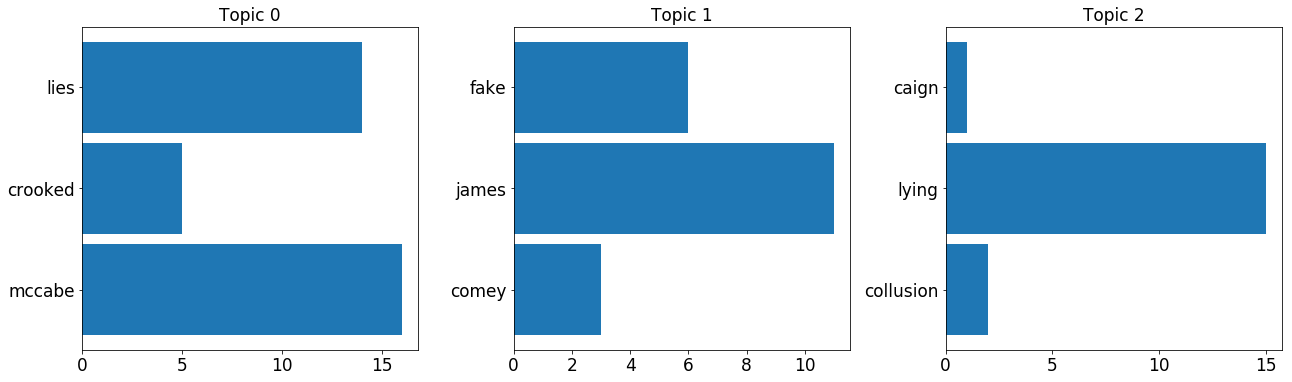

word: immigration, frequency: 0
word: china, frequency: 0
word: guns, frequency: 0
word: korea, frequency: 0
Model's perplexity: 105.972726627
Model's score': -876.678171826


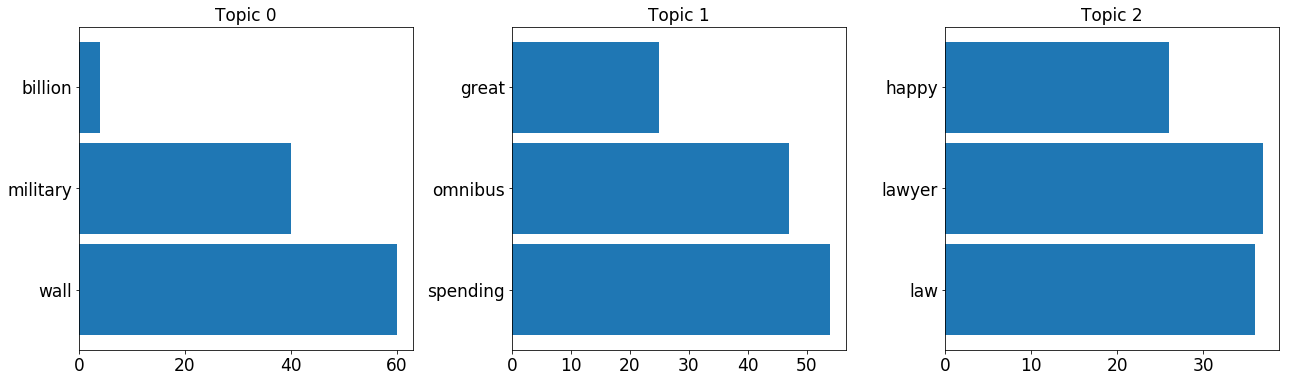

word: immigration, frequency: 0
word: china, frequency: 0
word: guns, frequency: 1
word: korea, frequency: 1
Model's perplexity: 106.967411501
Model's score': -710.223681845


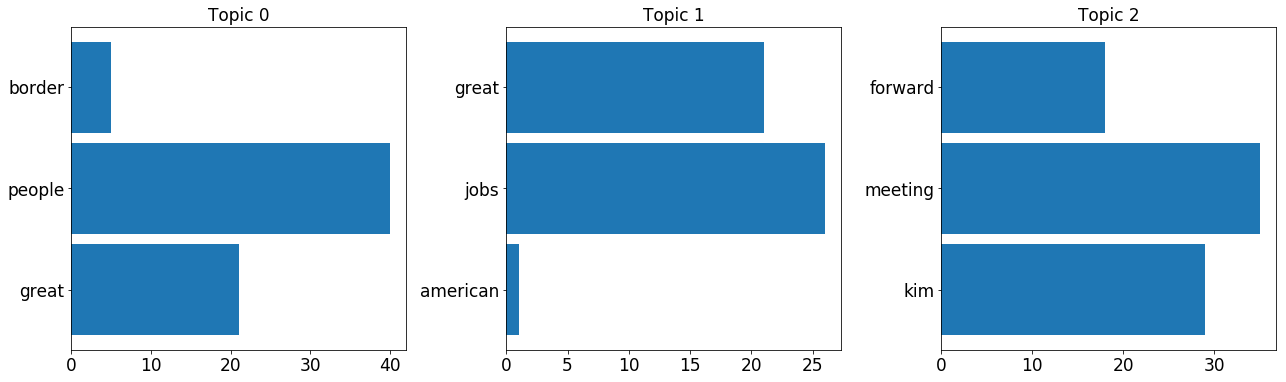

word: immigration, frequency: 1
word: china, frequency: 1
word: guns, frequency: 0
word: korea, frequency: 1
Model's perplexity: 216.832523489
Model's score': -2716.45826358


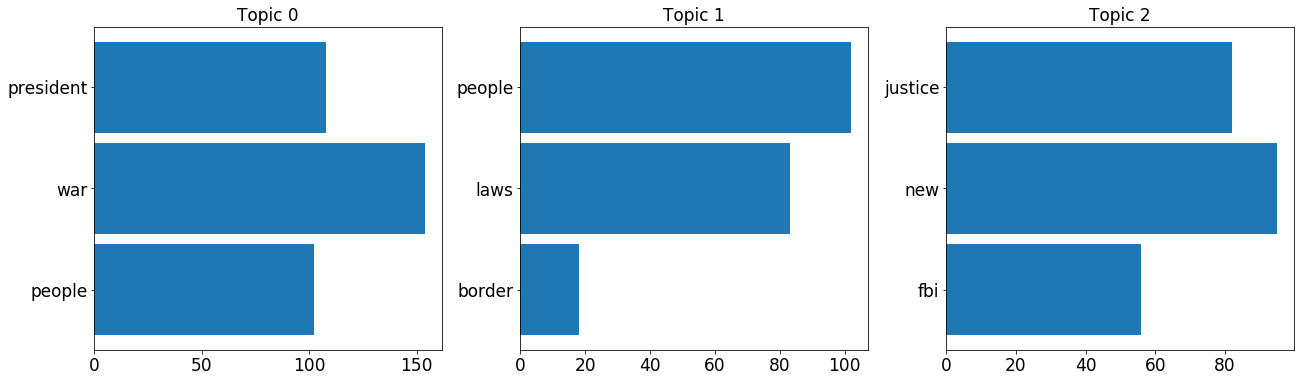

word: immigration, frequency: 4
word: china, frequency: 6
word: guns, frequency: 0
word: korea, frequency: 0
Model's perplexity: 192.114234088
Model's score': -1840.33155751


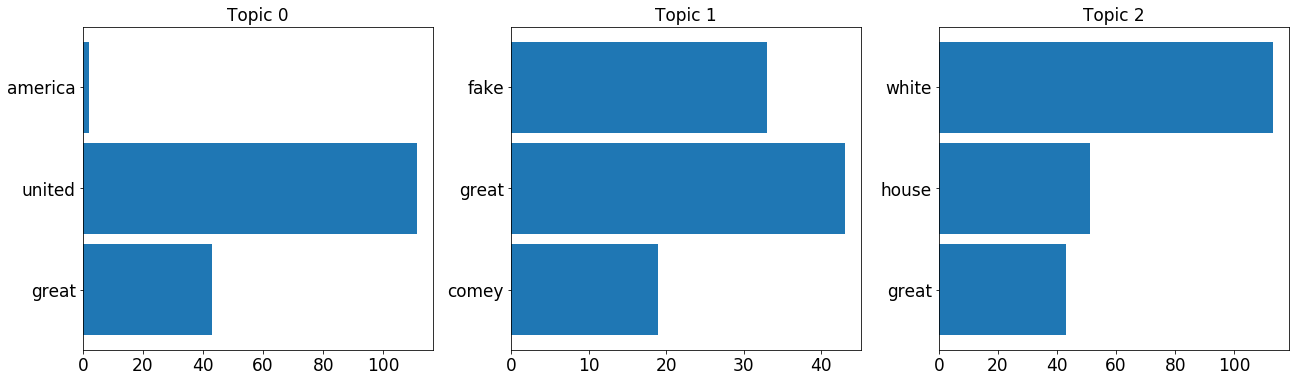

word: immigration, frequency: 0
word: china, frequency: 3
word: guns, frequency: 0
word: korea, frequency: 1
Model's perplexity: 343.498986064
Model's score': -4583.75956551


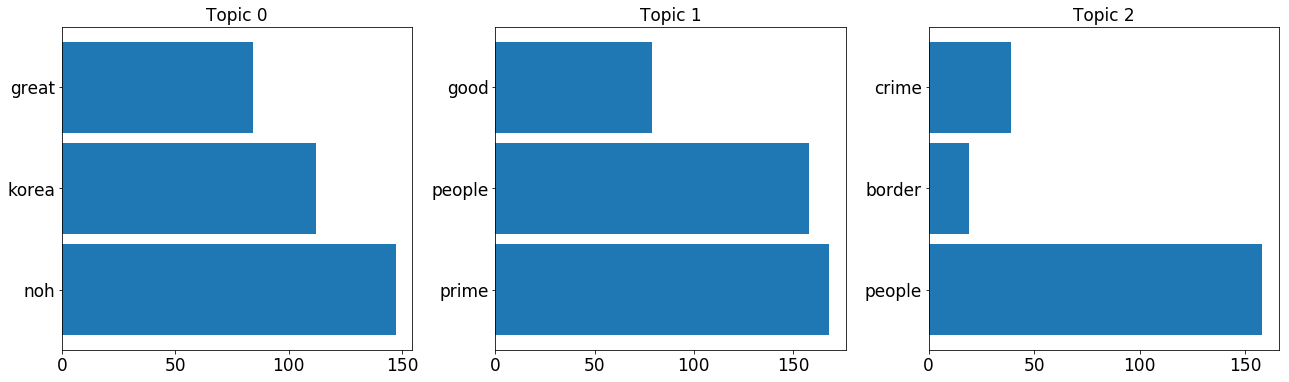

word: immigration, frequency: 0
word: china, frequency: 1
word: guns, frequency: 0
word: korea, frequency: 10
Model's perplexity: 187.83205046
Model's score': -1895.26845381


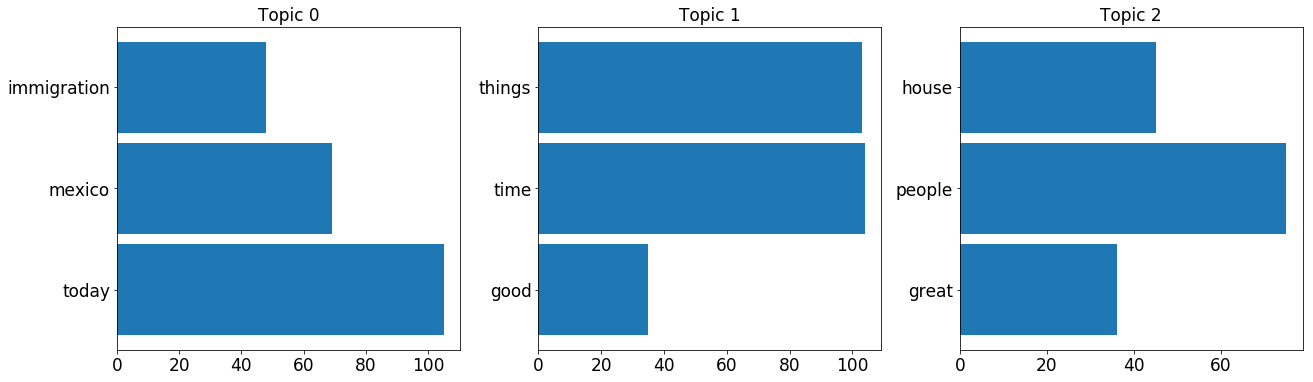

word: immigration, frequency: 3
word: china, frequency: 1
word: guns, frequency: 0
word: korea, frequency: 5
Model's perplexity: 185.702572284
Model's score': -1666.50267611


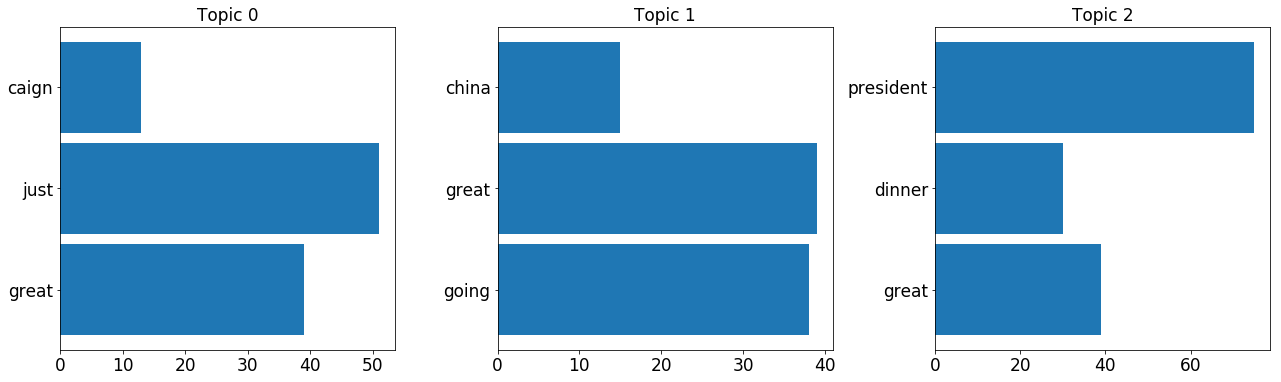

word: immigration, frequency: 3
word: china, frequency: 6
word: guns, frequency: 0
word: korea, frequency: 4
Model's perplexity: 172.205716257
Model's score': -1596.09383394


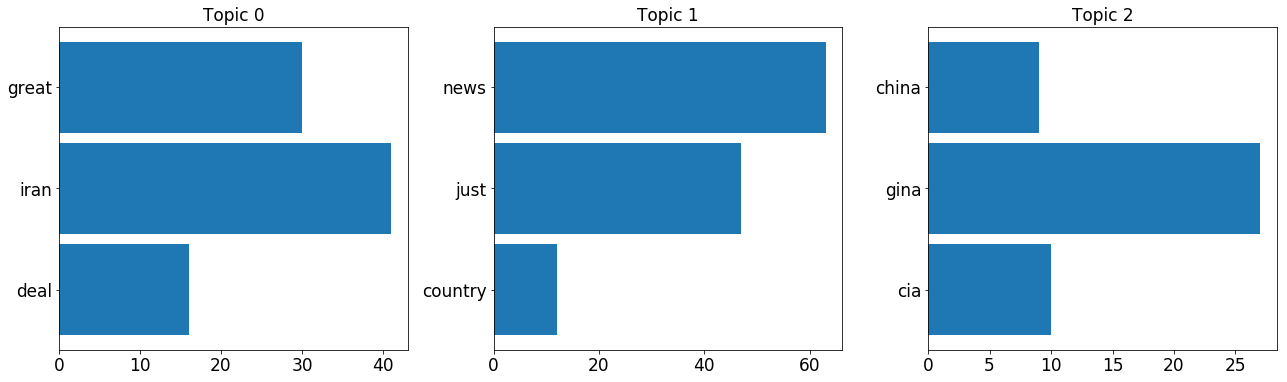

word: immigration, frequency: 0
word: china, frequency: 5
word: guns, frequency: 0
word: korea, frequency: 4
Model's perplexity: 255.267830295
Model's score': -2732.36046126


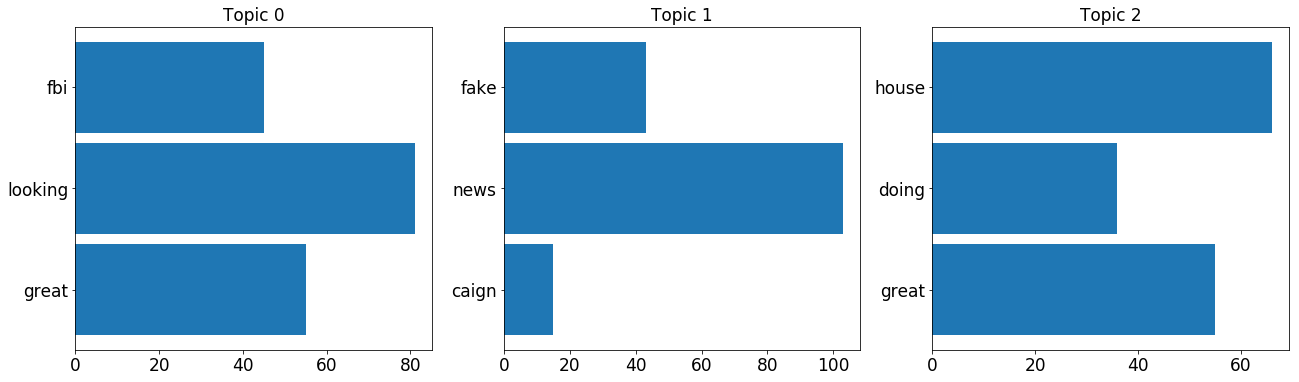

word: immigration, frequency: 0
word: china, frequency: 7
word: guns, frequency: 0
word: korea, frequency: 0
Model's perplexity: 147.417453742
Model's score': -1687.72471362


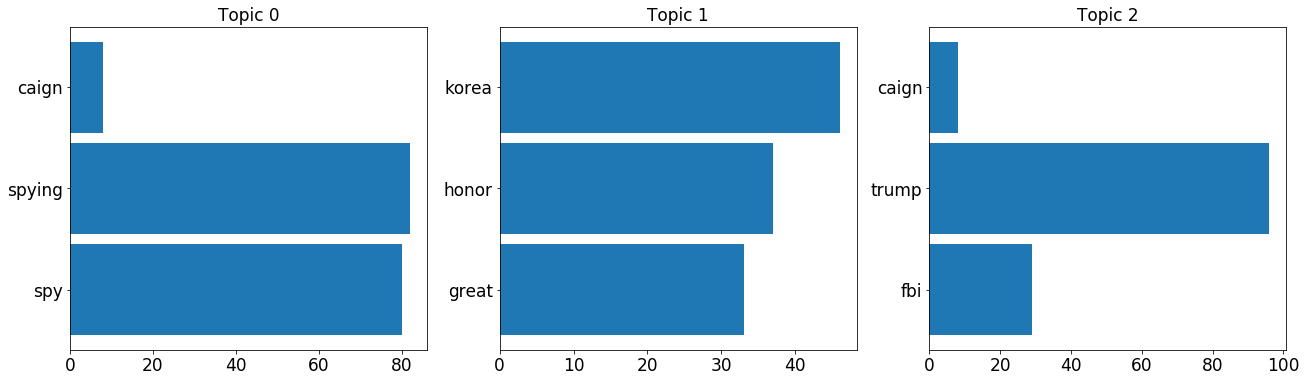

word: immigration, frequency: 0
word: china, frequency: 7
word: guns, frequency: 0
word: korea, frequency: 6


In [11]:
tweet_dataframe['week'] = tweet_dataframe['date'].dt.week
n_topics = 3
series = topic_series()
immigration_series = []
china_series = []
gun_series = []
korea_series = []

for i in range(tweet_dataframe['week'].min(),tweet_dataframe['week'].max() + 1): 
    # Merge 2 weeks
    #week_of_tweets = tweet_dataframe.loc[(tweet_dataframe['week'] == i) | (tweet_dataframe['week'] == i+1), :].copy()
    week_of_tweets = tweet_dataframe.loc[tweet_dataframe['week'] == i, :].copy()
    week_of_tweets.reset_index(drop = True, inplace = True)
    model = topic_model(week_of_tweets, n_topics) 
    # Create the LDA model and generate cluster labels
    lda, lda_transform, feature_names = model.lda_analysis()
    topics = model.display_topics(lda, feature_names) 
    #model.run_tsne(lda_transform)
    #model.drop_tweets(lda_transform) # Drop tweets below p cutoff.
    n_tweets = model.tweets_per_topic()
    data = model.get_data()
    #visualize_mpl(data, topics) 
    series.topic_change(i, topics, n_tweets)
    immigration_series.append(model.word_frequencies('immigration'))
    china_series.append(model.word_frequencies('china'))
    gun_series.append(model.word_frequencies('guns'))
    korea_series.append(model.word_frequencies('korea'))

Save word frequency list as dataframe

In [12]:
word_series = pd.DataFrame({'immigration': immigration_series, 
                            'china': china_series, 
                            'guns': gun_series,
                            'korea': korea_series,
                           })

word_series.to_csv('/home/timor/Documents/Git/Twitter-Mining/trump/data/word_frequencies.tsv', sep = '\t')

In [27]:
word_series

,immigration
0,0
1,0
2,1
3,4
4,0
5,0
6,3
7,3
8,0
9,0


Save the dataframe containing topics and tweet frequency per week

In [26]:
series.save_dataframe()

Focus on one week if necessary:

In [23]:
tweet_dataframe['week'] = tweet_dataframe['date'].dt.week
tweet_dataframe = tweet_dataframe.loc[tweet_dataframe['week'] == 18, :].copy()
tweet_dataframe.reset_index(drop = True, inplace = True)

Build topic model for all tweets in dataset.
In the cell below, initate the model, create topics, and plot

Model's perplexity: 149.41787514
Model's score': -1597.15226484


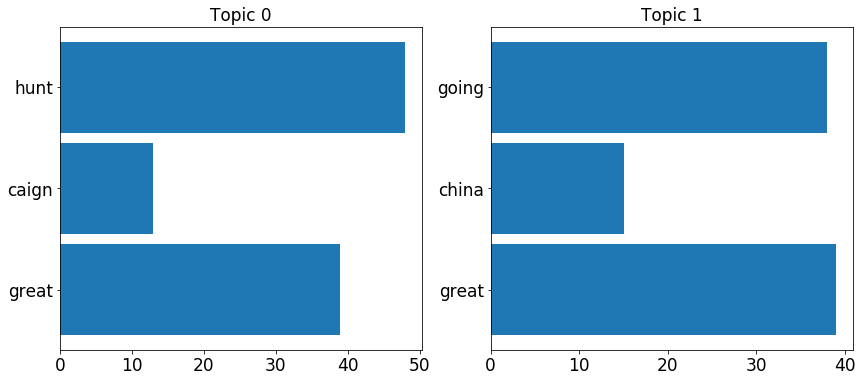

Dimensionality reduction...
Done


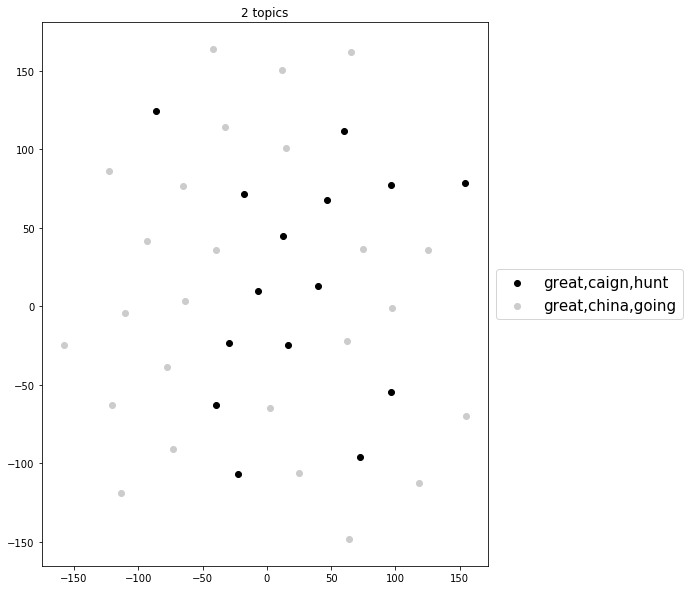

In [40]:
n_topics = 2
model = topic_model(tweet_dataframe, n_topics)
# Create the LDA model and generate cluster labels
lda, lda_transform, feature_names = model.lda_analysis()
topics = model.display_topics(lda, feature_names)
model.run_tsne(lda_transform) 
model.drop_tweets(lda_transform)
n_tweets = model.tweets_per_topic()
data = model.get_data()
visualize_mpl(data, topics) 


Testing topic_series() class

In [11]:
series = topic_series()
series.topic_change(1, topics, n_tweets)
series.print_dataframe()

                    topics_1  n_tweets_1
0         china,trade,russia          75
1           border,fake,news          63
2      great,today,president         119
3            kim,america,new          30
4  dollars,military,billions          22


The cells below contain the function necessary for plotting

In [4]:
def visualize_mpl(dataframe, topics):
    """
    Plot tsne data using matplotlib. When calling this function, no error or method need be
    provided. These arguments are only used by gridsearch.
    """
    
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(set(pd.Series(dataframe['labels'])))))
    # https://matplotlib.org/examples/color/colormaps_reference.html

    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_title('{0} topics'.format(len(topics)))
    
    # Thank you!:
    #https://stackoverflow.com/questions/46819664/how-to-add-labels-to-t-sne-in-python
    # https://www.kaggle.com/tilii7/t-sne-visualization/code

    for i, color in zip(range(len(topics)), colors):
        
        ax.scatter(dataframe.loc[dataframe['labels'] == i, 'x'],
                   dataframe.loc[dataframe['labels'] == i, 'y'], 
                   label = topics[i], c = color)
  
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)

    plt.show()
    
    fig.savefig('/home/timor/Documents/Git/Twitter-Mining/trump/data/trump_topics.png')
    
    plt.close()